In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree

import graphviz
from sklearn.externals.six import StringIO  
import pydot
from IPython.display import Image 

# Read and preprocess the data

In [2]:
raw_data = pd.read_csv('rawdata.csv', dtype=str)
raw_data.drop(columns = ['מס’'], inplace = True)  # Subject index is nnneccecary data
raw_data

,גיל הנבדק,משקל,תזונה,ספורט,מצב סוציואקונומי
0,58,גבוה,רגילה,ל,נמוך
1,60,גבוה,רגילה,Y,גבוה
2,32,גבוה,צמחונית,ל,נמוך
3,58,תקין,רגילה,כ,גבוה
4,663,נמוך,צמחונית,כ,גבוה
5,39,נמוך,רגילה,ל,נמוך
6,70,נמוך,צמחונית,כ,גבוה
7,27,72,צמחונית,ל,נמוך
8,45,נמוך,רגילה,ל,גבוה
9,64,תקין,רגילה,כ,גבוה


# Fix 'גיל הנבדק' column

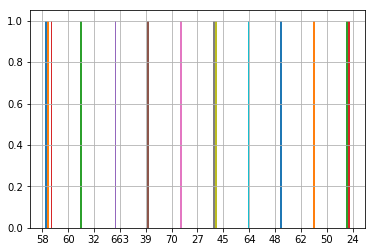

In [3]:
raw_data['גיל הנבדק'].hist()  # Clearly 663 is not a rational value for age 

In [4]:
raw_data['גיל הנבדק'].iloc[4] = 63  # As we see many occurrences of elder aged subjects,
                                  # we suppose a typing error, and the correct age is chosen to be 63
raw_data['גיל הנבדק'] = raw_data['גיל הנבדק'].astype(int) # Prepere to binning

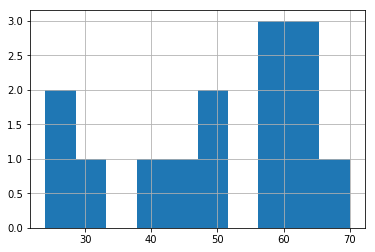

In [5]:
raw_data['גיל הנבדק'].hist()

In [6]:
# As we can see there are 3 age clusters, let's bin then
age_bins = [0,35,55,70]
raw_data['age_binned'] = pd.cut(raw_data['גיל הנבדק'], age_bins)
raw_data['age_binned']

0     (55, 70]
1     (55, 70]
2      (0, 35]
3     (55, 70]
4     (55, 70]
5     (35, 55]
6     (55, 70]
7      (0, 35]
8     (35, 55]
9     (55, 70]
10    (35, 55]
11    (55, 70]
12    (35, 55]
13     (0, 35]
Name: age_binned, dtype: category
Categories (3, interval[int64]): [(0, 35] < (35, 55] < (55, 70]]

# Fix 'משקל' column

In [7]:
raw_data['משקל'].values[7] = 'גבוה' # Studying on young vegans, 72 is clearly overweight(with normal high assumption)
                                  # source: https://www.nature.com/articles/0802300

In [8]:
raw_data['משקל']

0     גבוה
1     גבוה
2     גבוה
3     תקין
4     נמוך
5     נמוך
6     נמוך
7     גבוה
8     נמוך
9     תקין
10    תקין
11    תקין
12    גבוה
13    תקין
Name: משקל, dtype: object

# Fix 'ספורט' column

In [9]:
raw_data['ספורט'].iloc[1] = 'כ'  # typing error English Y for Yes instead of 'כ' for Hebrew

/home/eliran/anaconda3/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
pd.crosstab(raw_data['ספורט'], raw_data['משקל'])

משקל,גבוה,נמוך,תקין
ספורט,,,
?????,0,0,1
כ,1,2,4
ל,4,2,0


In [11]:
raw_data['ספורט'].iloc[13] = 'כ'  # As all other subjects with "fine" weight do sport, (4,0) likelihood ,
                                # I assumed that subject 13 also does sport

In [12]:
# Fixed Dataset
raw_data

,גיל הנבדק,משקל,תזונה,ספורט,מצב סוציואקונומי,age_binned
0,58,גבוה,רגילה,ל,נמוך,"(55, 70]"
1,60,גבוה,רגילה,כ,גבוה,"(55, 70]"
2,32,גבוה,צמחונית,ל,נמוך,"(0, 35]"
3,58,תקין,רגילה,כ,גבוה,"(55, 70]"
4,63,נמוך,צמחונית,כ,גבוה,"(55, 70]"
5,39,נמוך,רגילה,ל,נמוך,"(35, 55]"
6,70,נמוך,צמחונית,כ,גבוה,"(55, 70]"
7,27,גבוה,צמחונית,ל,נמוך,"(0, 35]"
8,45,נמוך,רגילה,ל,גבוה,"(35, 55]"
9,64,תקין,רגילה,כ,גבוה,"(55, 70]"


In [41]:
# 
data_X = pd.get_dummies(raw_data[['משקל', 'תזונה','ספורט', 'age_binned']]) #sklearn tree api format workes with hoteones
data_Y = raw_data[['מצב סוציואקונומי']]

In [42]:
data_X

,משקל_גבוה,משקל_נמוך,משקל_תקין,תזונה_צמחונית,תזונה_רגילה,ספורט_כ,ספורט_ל,"age_binned_(0, 35]","age_binned_(35, 55]","age_binned_(55, 70]"
0,1,0,0,0,1,0,1,0,0,1
1,1,0,0,0,1,1,0,0,0,1
2,1,0,0,1,0,0,1,1,0,0
3,0,0,1,0,1,1,0,0,0,1
4,0,1,0,1,0,1,0,0,0,1
5,0,1,0,0,1,0,1,0,1,0
6,0,1,0,1,0,1,0,0,0,1
7,1,0,0,1,0,0,1,1,0,0
8,0,1,0,0,1,0,1,0,1,0
9,0,0,1,0,1,1,0,0,0,1


In [43]:
data_Y

,מצב סוציואקונומי
0,נמוך
1,גבוה
2,נמוך
3,גבוה
4,גבוה
5,נמוך
6,גבוה
7,נמוך
8,גבוה
9,גבוה


In [137]:
tree_classifier = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=665)  # Random seed to reproducaible result
tree_classifier.fit(data_X,data_Y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=665,
            splitter='best')

In [138]:
tree_classifier.score(pd.get_dummies(data_X),data_Y)

0.9285714285714286

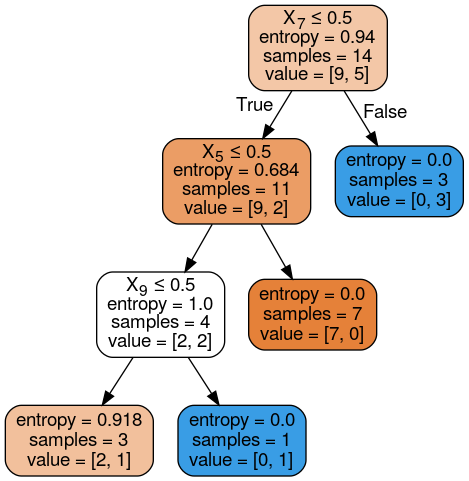

In [139]:
tree.export_graphviz(tree_classifier, out_file='tree.dot')
dot_data = StringIO()
tree.export_graphviz(tree_classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

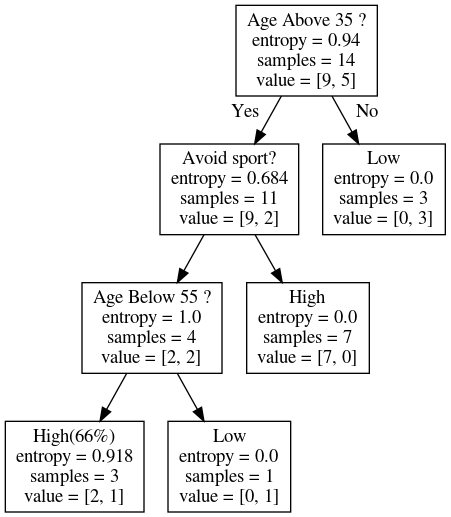

In [144]:
# Convert to understandable tree version

g = """digraph Tree {
node [shape=box] ;
0 [label="Age Above 35 ?\nentropy = 0.94\nsamples = 14\nvalue = [9, 5]"] ;
1 [label="Avoid sport?\nentropy = 0.684\nsamples = 11\nvalue = [9, 2]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="Yes"] ;
2 [label="Age Below 55 ?\nentropy = 1.0\nsamples = 4\nvalue = [2, 2]"] ;
1 -> 2 ;
3 [label="High(66%)\nentropy = 0.918\nsamples = 3\nvalue = [2, 1]"] ;
2 -> 3 ;
4 [label="Low\nentropy = 0.0\nsamples = 1\nvalue = [0, 1]"] ;
2 -> 4 ;
5 [label="High\nentropy = 0.0\nsamples = 7\nvalue = [7, 0]"] ;
1 -> 5 ;
6 [label="Low\nentropy = 0.0\nsamples = 3\nvalue = [0, 3]"] ;
0 -> 6 [labeldistance=2.5, labelangle=-45, headlabel="No"] ;
}"""

graph = pydot.graph_from_dot_data(g)  
Image(graph[0].create_png())

In [145]:
# Filter testing example
raw_data[(data_X.iloc[:,[8]]>0.5).values & (data_X.iloc[:,[5]]<0.5).values]

,גיל הנבדק,משקל,תזונה,ספורט,מצב סוציואקונומי,age_binned
5,39,נמוך,רגילה,ל,נמוך,"(35, 55]"
8,45,נמוך,רגילה,ל,גבוה,"(35, 55]"
12,50,גבוה,רגילה,ל,גבוה,"(35, 55]"


In [126]:
pd.DataFrame(data_X.columns)

,0
0,משקל_גבוה
1,משקל_נמוך
2,משקל_תקין
3,תזונה_צמחונית
4,תזונה_רגילה
5,ספורט_כ
6,ספורט_ל
7,"age_binned_(0, 35]"
8,"age_binned_(35, 55]"
9,"age_binned_(55, 70]"


# Conclusions

The model has 92 accuracy score.
I did not use the features Wight and Diet, 
I didn't need them as the model converted to almost shure decision without them.
The tree max depth was limited to 3 in order to avoid overfit.